<a href="https://colab.research.google.com/github/satoshi19989/transformer_practice/blob/main/transformer_time_series2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
!apt-get install git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [41]:
!git clone https://github.com/satoshi19989/transformer_practice.git

Cloning into 'transformer_practice'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 74 (delta 42), reused 37 (delta 15), pack-reused 0
Unpacking objects: 100% (74/74), 737.34 KiB | 3.41 MiB/s, done.


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [6]:
module_path = "/content/transformer_practice/modules"
sys.path.append(module_path)

# 対象データ確認
- ドイツのイエナにあるマックスプランク生物地球化学研究所の気象観測所で記録された気象時系列データセットを使う。
- 14種類の数値（気温、気圧、温度、風向 etc）を10分おきに記録した数年分のデータ
- 今回は公開されているもので2009~2016年のデータを使用

In [7]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-27 22:26:23--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.226.120, 54.231.48.147, 52.217.194.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.226.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  39.0MB/s    in 0.3s    

2023-02-27 22:26:23 (39.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [8]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420451


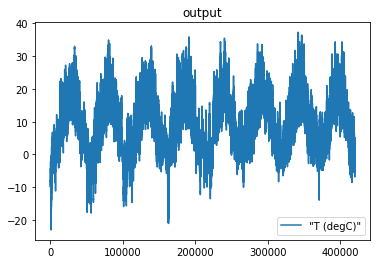

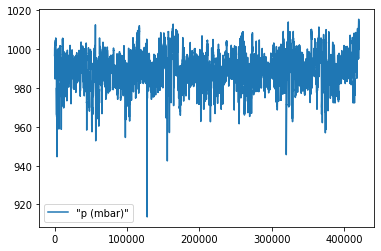

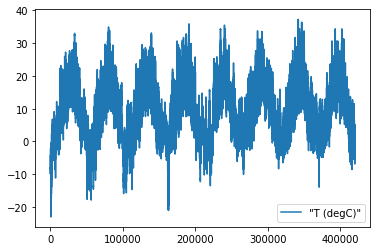

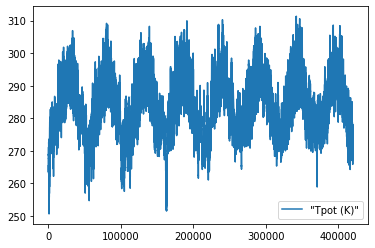

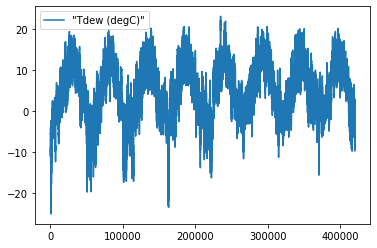

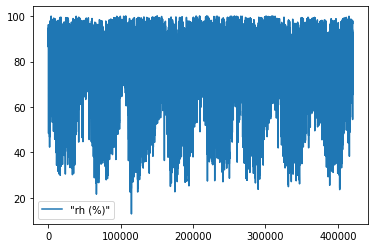

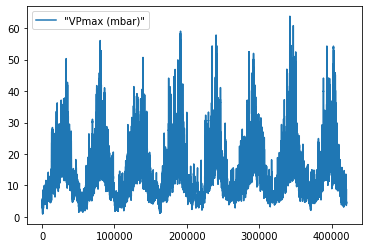

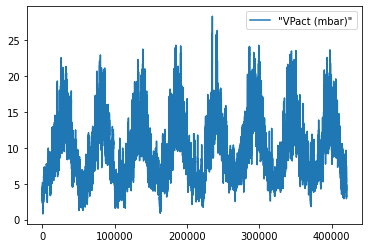

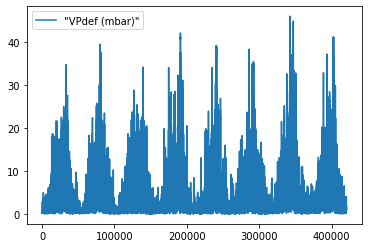

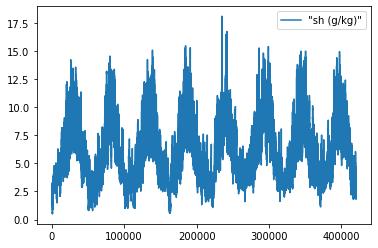

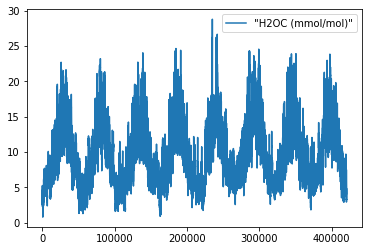

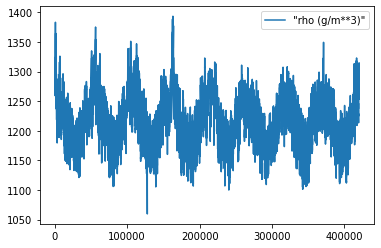

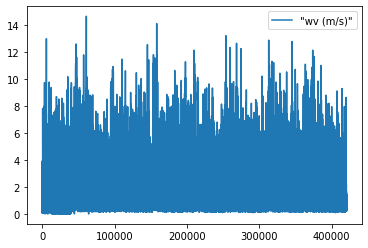

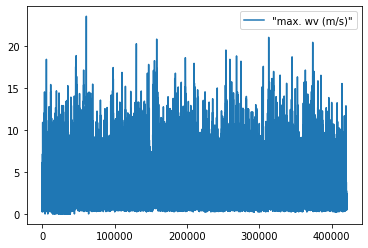

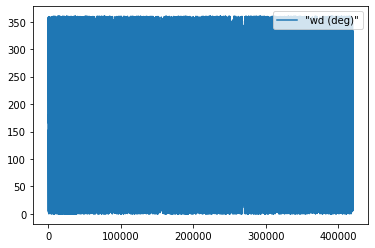

In [129]:
from matplotlib import pyplot as plt

#例1
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


plt.plot(temperature, label=header[2])
plt.title("output")
plt.legend()

for i, seq in enumerate(raw_data.T):
  plt.figure()
  plt.plot(seq, label=header[i+1])
  plt.legend()

# 学習用データ生成
- 通常のNN用データセットとtransformer用のデータセットを作成する。
- transformerのデータセットにはdecoder入力がある分、公平な比較にはならないが、より適したデータセットの生成方法がわからなかったため、このようにした。
- 10分おきの時系列を6ステップ間隔でサンプリングして1時間おきのデータセットを作成する。

In [116]:
#データセット生成クラスの実行例

from generate_data import PreprocessData
sd = np.arange(1000, dtype='float64').reshape(-1,1)

sampling_rate = 6
sequence_length = 7
pred_points = 4
#delay = sampling_rate * (sequence_length + 24 - 1)
delay = sampling_rate * (sequence_length )
batch_size = 3

dg = PreprocessData(sd, 
                      sd, 
                      sequence_length, 
                      delay, 
                      batch_size, 
                      sampling_rate, 
                      False)

train_dataset_single, val_dataset_single, test_dataset_single = dg.generate_dataset_single()
train_dataset, val_dataset, test_dataset = dg.generate_dataset_multistep(pred_points)


for x,y in train_dataset_single:
    print('%s => %s' % (x[0,:,0], y[0,:]))
    break

for x,y in train_dataset:
    print('%s => %s' % (x[0,:,0], y[0,:,0]))
    break

num_train_samples: 500
num_val_samples: 250
num_test_samples: 250
66
(934, 1) (934,)
tf.Tensor([239. 245. 251. 257. 263. 269. 275.], shape=(7,), dtype=float64) => tf.Tensor([281.], shape=(1,), dtype=float64)
[236. 242. 248. 254. 260. 266. 272. 278. 284. 290.] => [278. 284. 290. 296.]


In [117]:
#本対象データに対する実行

sampling_rate = 6
sequence_length = 120
pred_points = 10
#delay = sampling_rate * (sequence_length + 24 - 1)
delay = sampling_rate * (sequence_length )
batch_size = 256


dg = PreprocessData(raw_data, 
                      temperature, 
                      sequence_length, 
                      delay, 
                      batch_size, 
                      sampling_rate)

train_dataset_single, val_dataset_single, test_dataset_single = dg.generate_dataset_single()
train_dataset, val_dataset, test_dataset = dg.generate_dataset_multistep(pred_points)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114
780
(419671, 14) (419671,)


In [122]:
#時系列->点の場合
for x,y in train_dataset_single:
    print('%s => %s' % (x.shape, y.shape))
    break

#時系列->時系列の場合
for x,y in train_dataset:
    print('%s => %s' % (x.shape, y.shape))
    enc_input = x[:,:sequence_length]
    dec_input = x[:,sequence_length-1:]
    print('enc_input %s, dec_input %s => %s' % (enc_input.shape, dec_input.shape, y.shape))
    break

(256, 120, 14) => (256,)
(256, 129, 14) => (256, 10)
enc_input (256, 120, 14), dec_input (256, 10, 14) => (256, 10)


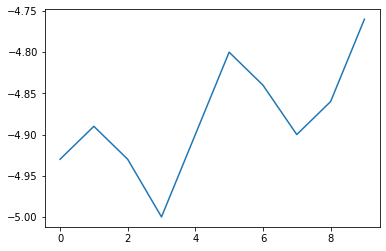

In [13]:
plt.figure()
plt.plot(temperature[delay:delay+10])

(256, 129, 14) => (256, 10)
(256, 10, 14) (256, 10)


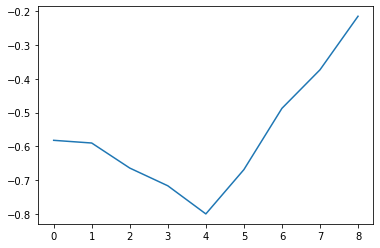

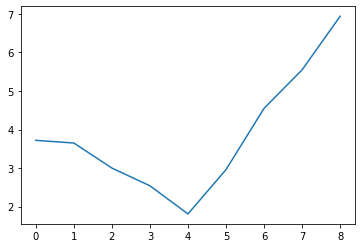

In [97]:
for x,y in train_dataset:
    #x, y = train_dataset[i]
    print('%s => %s' % (x.shape, y.shape))
    enc_input = x[:,:sequence_length]
    dec_input = x[:,sequence_length-1:]
    print(dec_input.shape, y.shape)

    plt.figure()
    plt.plot(dec_input[0,1:,1])

    plt.figure()
    plt.plot(y[0,:-1])
    break

# 機械学習を使わない予測
- まずは機械学習を使わない予測として、今の気温をそのまま1時間後の気温の予測値とした場合の平均絶対誤差を計算する。

In [137]:
def evaluate_naive_method(dataset, mean, std):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset_single, dg.mean, dg.std):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset_single, dg.mean, dg.std):.2f}")

Validation MAE: 0.68
Test MAE: 0.72


# 基本的なNNを試す

In [138]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(train_dataset_single, 
                    epochs=10,
                    batch_size=batch_size, 
                    validation_data=val_dataset_single,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras")

print(f"Test MAE: {model.evaluate(test_dataset_single)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 56s 68ms/step - loss: 7.0998 - mae: 1.8968 - val_loss: 4.9108 - val_mae: 1.7756
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 2.7597 - mae: 1.2827 - val_loss: 1.5717 - val_mae: 0.9750
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 2.0899 - mae: 1.1193 - val_loss: 2.1795 - val_mae: 1.1696
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 1.7219 - mae: 1.0138 - val_loss: 1.6734 - val_mae: 1.0150
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 1.5010 - mae: 0.9423 - val_loss: 0.9709 - val_mae: 0.7495
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 1.3568 - mae: 0.8934 - val_loss: 1.3268 - val_mae: 0.9031
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 1.2416 - mae: 0.8527 - val_loss: 1.5901 - val_mae: 0.9961
Epoch 8/10
819/819 [==============================] - 55s 67ms

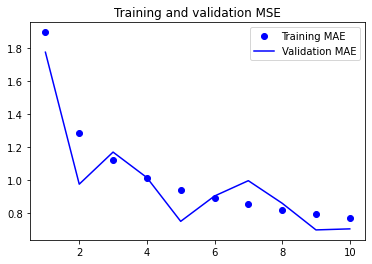

In [139]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MSE")
plt.legend()
plt.show()

8/8 [==============================] - 0s 3ms/step


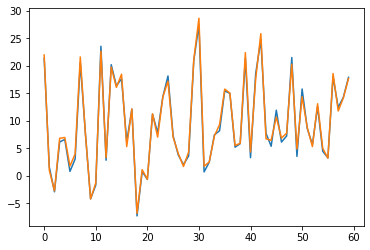

In [147]:
end_point = 60

for x, y in test_dataset_single:
  y_true = y
  y_pred =model.predict(x)
  plt.figure()
  plt.plot(y_true[:end_point])
  plt.plot(y_pred[:end_point,0])
  break

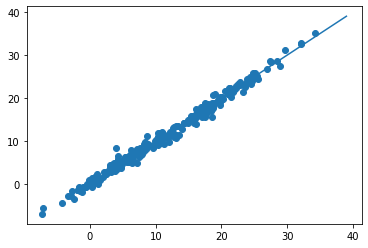

In [149]:
x = np.arange(-2, 40, 1)
y = x

plt.figure()
plt.scatter(y_true, y_pred[:,0])
plt.plot(x, y)

# トランスフォーマの構築

In [151]:
dmodel = 28

In [152]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from transformer_layers import Encoder, TransformerDecoder
import transformer_core as tfc
from transformer_core import TransformerBaseTimeSeriesForecastModel, EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel

# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)



#inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# outputs = EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel(num_layers=1, # Multi-head Attentionの繰り返し数
#                                                   d_model = dmodel, # embeddingの次元
#                                                   num_heads=1,  # Multi-head Attentionのヘッド数
#                                                   dff = 30,      #全結合層のユニット数
#                                                   pe_input = sequence_length, 
#                                                   window_width = sequence_length, 
#                                                   rate=0.2)(inputs)

inputs = keras.Input(shape=(sequence_length+pred_points -1, raw_data.shape[-1]))                                 
outputs = TransformerBaseTimeSeriesForecastModel(num_layers=2, # Multi-head Attentionの繰り返し数
                                                  d_model = dmodel, # embeddingの次元
                                                  num_heads=2,  # Multi-head Attentionのヘッド数
                                                  dff = 30,      #全結合層のユニット数
                                                  pe_input = sequence_length, 
                                                  pe_target = pred_points,
                                                  window_width = sequence_length, 
                                                  rate=0.2)(inputs)

model = keras.Model(inputs, outputs)
model.compile(loss=criterion, optimizer=optimizer, metrics=['mae'])




In [102]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 14)]         0         
                                                                 
 transformer_base_time_serie  (None, 10, 1)            34141     
 s_forecast_model (Transform                                     
 erBaseTimeSeriesForecastMod                                     
 el)                                                             
                                                                 
Total params: 34,141
Trainable params: 34,141
Non-trainable params: 0
_________________________________________________________________


In [103]:
import shutil

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.dirname('/content/models/cp.ckpt'),
                                                 save_weights_only=True,
                                                 verbose=1)

#callbackを使って最も性能の良いモデルを保存
callbacks = [
    lr_decay
    , cp_callback
]
#history=model.fit(input, y_train, batch_size=batch_size, epochs=10, validation_data=val_data, callbacks=callbacks,verbose=2)
history=model.fit(train_dataset, batch_size=batch_size, epochs=10, validation_data=val_dataset, callbacks=callbacks,verbose=2)
# model = keras.models.load_model("jena_dense.keras", 
#                                 custom_objects={"EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel":EncoderWithMultiHeadAttentionBaseTimeSeriesForecastModel})

shutil.move("models.index", "/content/drive/MyDrive/models/models.index")
shutil.move("models.data-00000-of-00001", "/content/drive/MyDrive/models/models.data-00000-of-00001")
shutil.move("checkpoint", "/content/drive/MyDrive/models/checkpoint")

Epoch 1/10

Epoch 1: saving model to /content/models
819/819 - 646s - loss: 166.0943 - mae: 10.6718 - val_loss: 180.7862 - val_mae: 11.2013 - lr: 0.0000e+00 - 646s/epoch - 789ms/step
Epoch 2/10

Epoch 2: saving model to /content/models
819/819 - 638s - loss: 99.0295 - mae: 7.9223 - val_loss: 54.2652 - val_mae: 5.5877 - lr: 1.4967e-05 - 638s/epoch - 779ms/step
Epoch 3/10

Epoch 3: saving model to /content/models
819/819 - 642s - loss: 45.3872 - mae: 4.8582 - val_loss: 37.0625 - val_mae: 4.2548 - lr: 2.9933e-05 - 642s/epoch - 784ms/step
Epoch 4/10

Epoch 4: saving model to /content/models
819/819 - 636s - loss: 31.2972 - mae: 3.7357 - val_loss: 25.3499 - val_mae: 3.1333 - lr: 4.4900e-05 - 636s/epoch - 776ms/step
Epoch 5/10

Epoch 5: saving model to /content/models
819/819 - 640s - loss: 19.9366 - mae: 2.8097 - val_loss: 14.4361 - val_mae: 2.1363 - lr: 5.9867e-05 - 640s/epoch - 782ms/step
Epoch 6/10

Epoch 6: saving model to /content/models
819/819 - 643s - loss: 10.4858 - mae: 1.9544 - v

'/content/drive/MyDrive/models/checkpoint'

In [153]:
checkpoint_path = "/content/drive/MyDrive/models/models"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)

# Loads the weights
model.load_weights(checkpoint_path)

In [154]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 99s 241ms/step - loss: 1.0182 - mae: 0.7162
Test MAE: 0.72


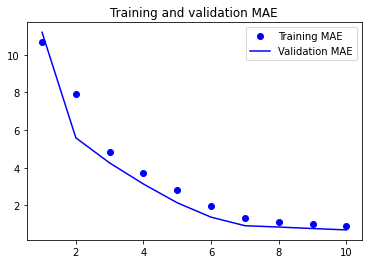

In [105]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

samples shape: (256, 129, 14)
targets value: (256, 10)
preds value: (256, 10, 1)


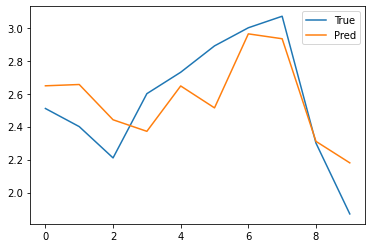

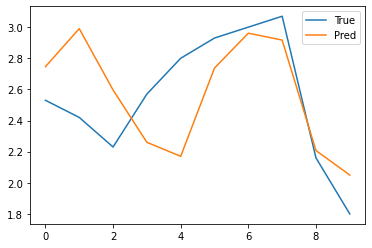

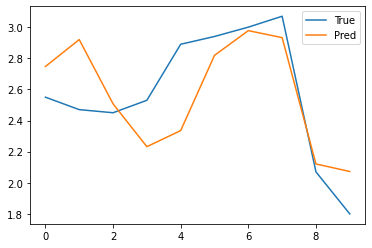

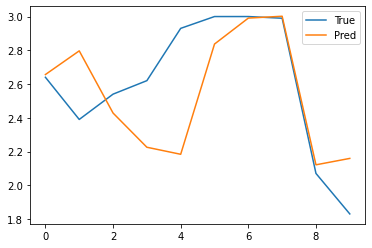

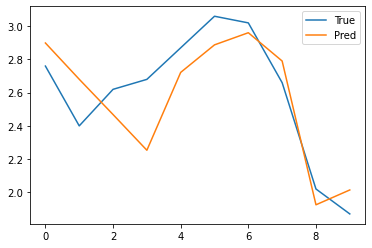

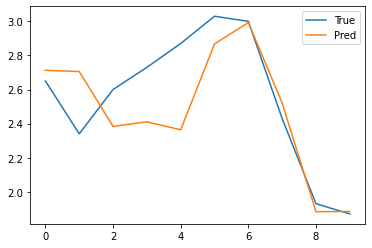

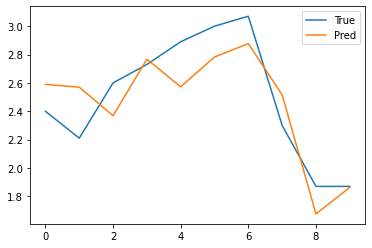

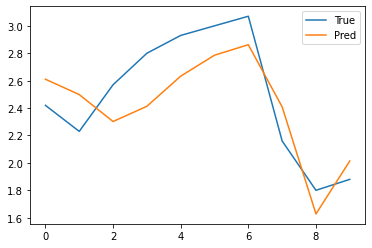

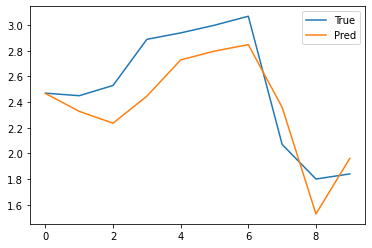

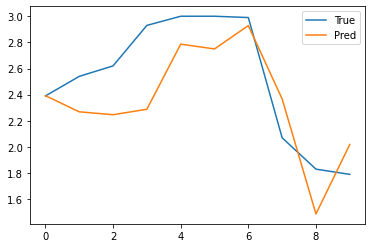

In [157]:
for samples, targets in test_dataset:
    print("samples shape:", samples.shape)
    print("targets value:", targets.shape)
    
    targets_pred = model.predict(samples, verbose=0)
    print("preds value:", targets_pred.shape)  

    for i in range(10):
      plt.figure()
      plt.plot(targets[i], label="True")
      plt.plot(targets_pred[i,:,0], label="Pred")
      plt.legend()
      plt.show()

    break



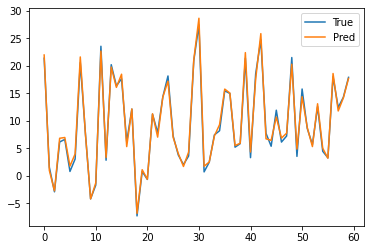

In [160]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

start_point = 0
end_point = 60

plt.figure()
plt.plot(y_true[start_point:end_point], label="True")
plt.plot(y_pred[start_point:end_point], label="Pred")
plt.legend()
plt.show()

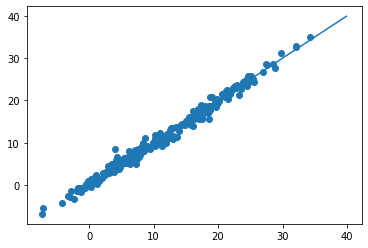

In [164]:
x = np.arange(-2, 40, 0.1)
y = x

plt.figure()
plt.scatter(y_true, y_pred)
plt.plot(x, y)